<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 4: Bayes' Rule
### Miscellaneous images

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
sns.reset_orig()  # Turn seaborn off for now - default formatting looks better

In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [4]:
##### SECTION 1: Bias from flips
# Show how we find bias over multiple flips

In [42]:
def get_flips(bias, num_flips):
    flips = np.random.uniform(low=0, high=1, size=num_flips)
    heads = [f < bias for f in flips]
    heads = [int(h==True) for h in heads]
    return heads

In [66]:
def plot_bias(num_flips):
    plt.figure(figsize=(12,9))
    for coin_number, bias in enumerate([.2, .5, .8]):
        np.random.seed(int(1000*bias))
        heads = get_flips(bias, num_flips)
        plt.subplot(3, 2, 1+(2*coin_number))
        pheads = [(2*h)-1 for h in heads]
        plt.bar(range(len(pheads)), pheads, width=0.8)
        plt.ylim(-1.2, 1.2)
        plt.yticks([-1, 0, 1], ['Tails', 'bias='+str(bias), 'Heads'], fontsize=14)
        plt.xticks(fontsize=14)
        plt.subplot(3, 2, 2+(2*coin_number))
        bias_estimate = np.zeros(num_flips)
        for i, b in enumerate(heads):
            bias_estimate[i] = np.sum(heads[:i+1])/(i+1)
        plt.plot(bias_estimate, lw=2)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim(0,1)
    file_helper.save_figure('bias-from-flips')
    plt.show()

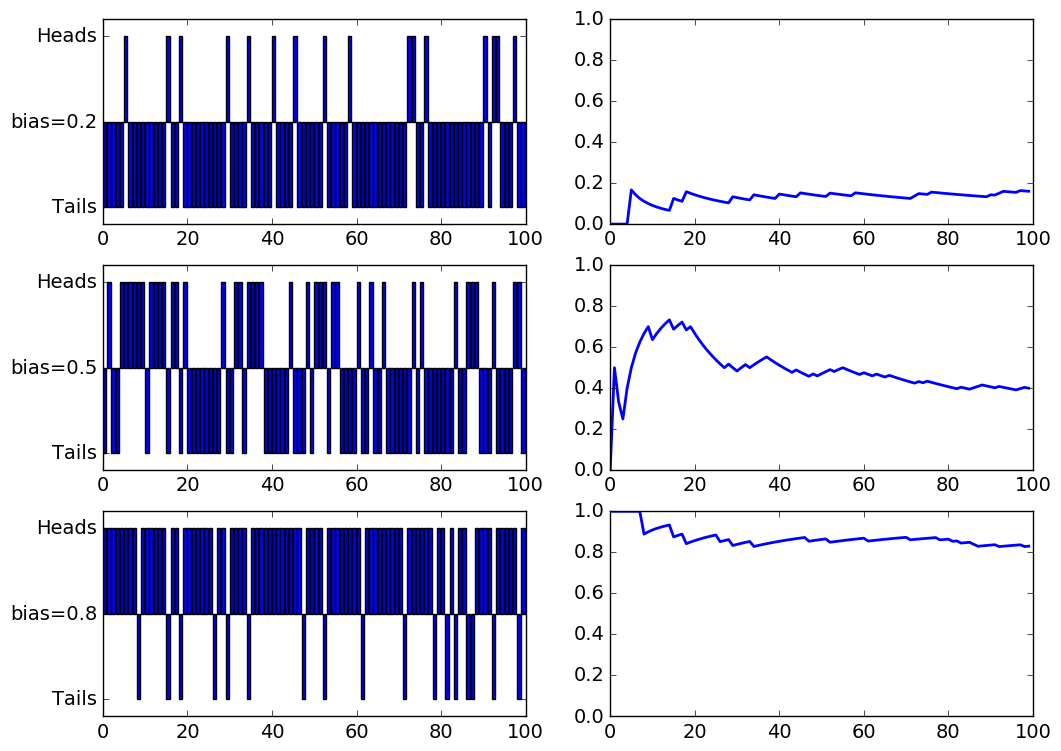

In [67]:
plot_bias(100)

In [4]:
##### SECTION 2: Coin Flip Bars (CFB)
# Make the bar charts for multiple flips

In [5]:
def CFB_compute_posteriors(flip_is_heads, prior_F, prior_R, bias_F, bias_R):
    if flip_is_heads:
        likelihood_F = bias_F  # P(H|F)
        likelihood_R = bias_R  # P(H|R)
    else:
        likelihood_F = 1-bias_F  # P(T|F)
        likelihood_R = 1-bias_R  # P(T|R)
    evidence = (prior_F * likelihood_F) + (prior_R * likelihood_R) # area(TF)+area(TR)
    posterior_F = (prior_F * likelihood_F)/evidence
    posterior_R = (prior_R * likelihood_R)/evidence
    return [posterior_F, posterior_R]  

In [6]:
def CFB_make_flip_sequence(number_of_flips, coin_bias):
    seq = [int(v<coin_bias) for v in np.linspace(0,1,number_of_flips)]
    np.random.shuffle(seq)
    return seq

In [7]:
def CFB_plot_confidences(priors_list, flips_list, bias_R, unknown_coin_bias, filename):
    plt.figure(figsize=(10,5))
    indices = np.arange(len(priors_list))
    bar_width = 0.75
    
    data_F = [priors_list[i][0] for i in range(len(priors_list))]
    data_R = [priors_list[i][1] for i in range(len(priors_list))]    
    p_R = plt.bar(indices, data_R, bar_width, label='Rigged', color='#b30000', edgecolor = "none")
    p_F = plt.bar(indices, data_F, bar_width, label='Fair', bottom=data_R, color='#fee090', edgecolor = "none")
    
    plt.xlim(0, len(data_F))
    plt.ylim(0, 1)
    tick_pos = [i+(bar_width/2) for i in range(len(data_F))] 
    tick_labels = [['T','H'][i] for i in flips_list]
    tick_labels.insert(0, '')
    plt.xticks(tick_pos, tick_labels, fontsize=15)

    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Successive Flips', fontsize=15)
    plt.title('Rigged Coin Bias='+str(bias_R)+', Flips are '+str(100*unknown_coin_bias)+'% Heads')
    ax = plt.gca()
    ax.legend(loc='center right')

    filename = 'which-coin-rigged-'+str(bias_R)+'-unknown-'+str(unknown_coin_bias)
    file_helper.save_figure(filename)
    plt.show()

In [8]:
def CFB_make_plot(flips_list, prior_F, prior_R, bias_F, bias_R, unknown_coin_bias):
    priors_list = [[prior_F, prior_R]]
    for i in range(len(flips_list)):    
        flip_is_heads = flips_list[i]
        posteriors = CFB_compute_posteriors(flip_is_heads, prior_F, prior_R, bias_F, bias_R)
        (prior_F, prior_R) = posteriors
        priors_list.append((prior_F, prior_R))
    CFB_plot_confidences(priors_list, flips_list, bias_R, unknown_coin_bias, "tmp.png")

In [9]:
def CFB_run_flip_simulation(prior_F, prior_R, bias_F, bias_R, 
                            number_of_flips, unknown_coin_bias):
    np.random.seed(42)
    flips_list = CFB_make_flip_sequence(number_of_flips, unknown_coin_bias)
    CFB_make_plot(flips_list, prior_F, prior_R, bias_F, bias_R, unknown_coin_bias)

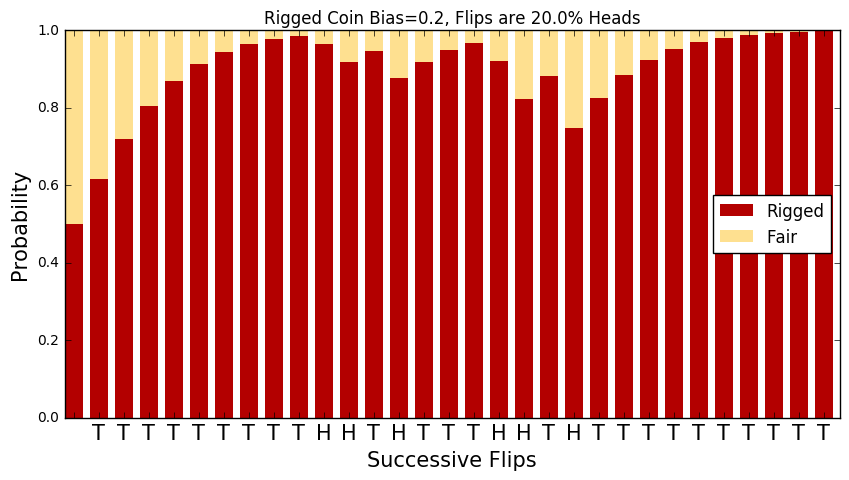

In [10]:
CFB_run_flip_simulation(
    prior_F = .5, # P(F), probability we have the Fair coin
    prior_R = .5, # P(R), probability we have the Rigged coin
    bias_F = .5,  # fair coin has no bias
    bias_R = .2, # rigged coin will show heads 20% of the time

    number_of_flips = 30,
    unknown_coin_bias = .2 # the actual bias in the coin we're flipping
    )

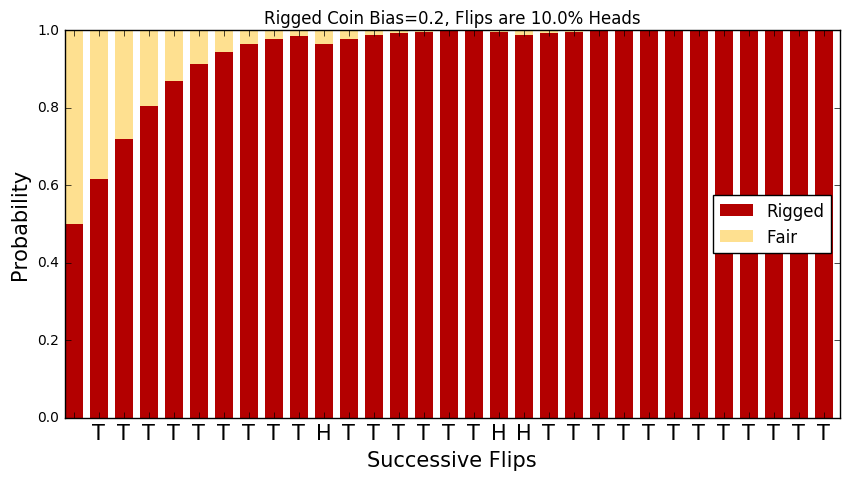

In [11]:
CFB_run_flip_simulation(
    prior_F = .5, # P(F), probability we have the Fair coin
    prior_R = .5, # P(R), probability we have the Rigged coin
    bias_F = .5,  # fair coin has no bias
    bias_R = .2, # rigged coin will show heads 20% of the time

    number_of_flips = 30,
    unknown_coin_bias = .1 # the actual bias in the coin we're flipping
    )

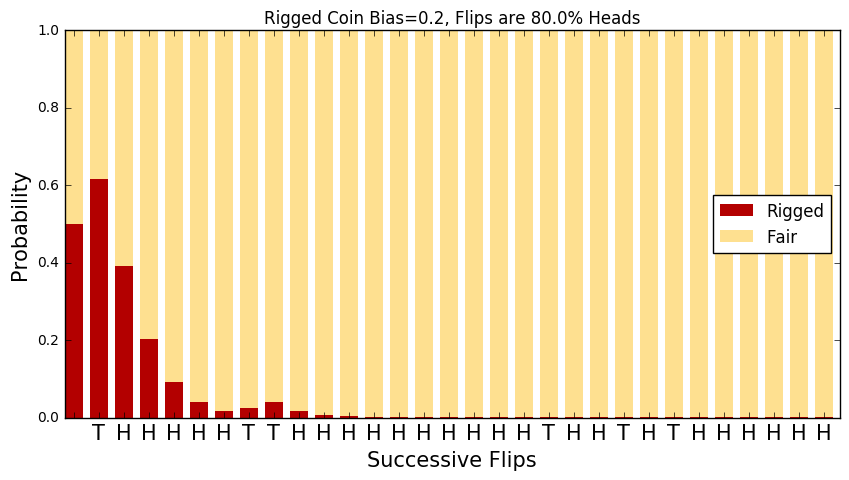

In [12]:
CFB_run_flip_simulation(
    prior_F = .5, # P(F), probability we have the Fair coin
    prior_R = .5, # P(R), probability we have the Rigged coin
    bias_F = .5,  # fair coin has no bias
    bias_R = .2, # rigged coin will show heads 20% of the time

    number_of_flips = 30,
    unknown_coin_bias = .8 # the actual bias in the coin we're flipping
    )

In [13]:
##### SECTION 3: Coin Flip Grid (CFG)
# Make a grid of bar charts for multiple flips
# Some of the code above is duplicated with only slight variations,
# because it was written later in a different notebook. I'm sure this
# can be combined and cleaned up.

In [14]:
def CFG_plot_confidences(priors_list, flips_list, filename):
    indices = np.arange(len(priors_list))
    bar_width = 1
    data_F = [priors_list[i][0] for i in range(len(priors_list))]
    data_R = [priors_list[i][1] for i in range(len(priors_list))]    
    p_R = plt.bar(indices, data_R, bar_width, label='Rigged', color='#b30000', edgecolor = "none")
    p_F = plt.bar(indices, data_F, bar_width, label='Fair', bottom=data_R, color='#fee090', edgecolor = "none")

    plt.xlim(0, len(data_F))
    plt.ylim(0, 1)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [15]:
def CFG_make_plot(flips_list, prior_F, prior_R, bias_F, bias_R):
    priors_list = [[prior_F, prior_R]]
    for i in range(len(flips_list)):    
        flip_is_heads = flips_list[i]
        posteriors = CFB_compute_posteriors(flip_is_heads, prior_F, prior_R, bias_F, bias_R)
        (prior_F, prior_R) = posteriors
        priors_list.append((prior_F, prior_R))
    CFG_plot_confidences(priors_list, flips_list, "tmp.png")

In [16]:
def CFG_make_grid(number_of_flips):
    rows = 10
    cols = 10
    
    plt.clf()
    fig, ax = plt.subplots(cols, rows,
        figsize=(10,10), sharex=True, sharey=False)

    y = 0
    for unknown_coin_bias in np.linspace(.9, .1, rows): # because subplots go top-down
        x = 0
        for bias_R in np.linspace(.1, .9, cols):
            #print("Making cell for unknown_coin_bias=",unknown_coin_bias," bias_R=",bias_R)
            flips_list = CFB_make_flip_sequence(number_of_flips, unknown_coin_bias)
            bias_F = .5  # fair coin has no bias
            prior_F = .5 # P(F), probability we have the Fair coin
            prior_R = .5 # P(R), probability we have the Rigged coin
            plt.subplot(cols, rows, (y*cols)+x+1)
            CFG_make_plot(flips_list, prior_F, prior_R, bias_F, bias_R)
            x += 1
        y += 1

    # big axes around plot thanks to http://matplotlib.1069221.n5.nabble.com/file/n61/grid_histogram.py
    axtot = fig.add_subplot(1,1,1)
    # don't draw plot area, we only want the axes.
    axtot.axesPatch.set_alpha(0.)

    # only draw the bottom (x) and left (y) axes
    axtot.xaxis.set_ticks_position('bottom')
    axtot.yaxis.set_ticks_position('left')
    axtot.spines['top'].set_visible(False)
    axtot.spines['right'].set_visible(False)
    axtot.tick_params(axis='both', which='major', labelsize=15)

    # pull the axes outwards, away from the plot grid
    axtot.spines['bottom'].set_position(('outward',20))
    axtot.spines['left'].set_position(('outward',20))

    # label the over-all axes
    axtot.set_xlabel('Rigged Coin Bias', fontsize=15)
    axtot.set_ylabel('Flip Sequence Bias', fontsize=15)

    plt.tight_layout()
    filename = 'which-coin-bars-grid-flipcount-'+str(number_of_flips)
    file_helper.save_figure(filename)
    plt.show()

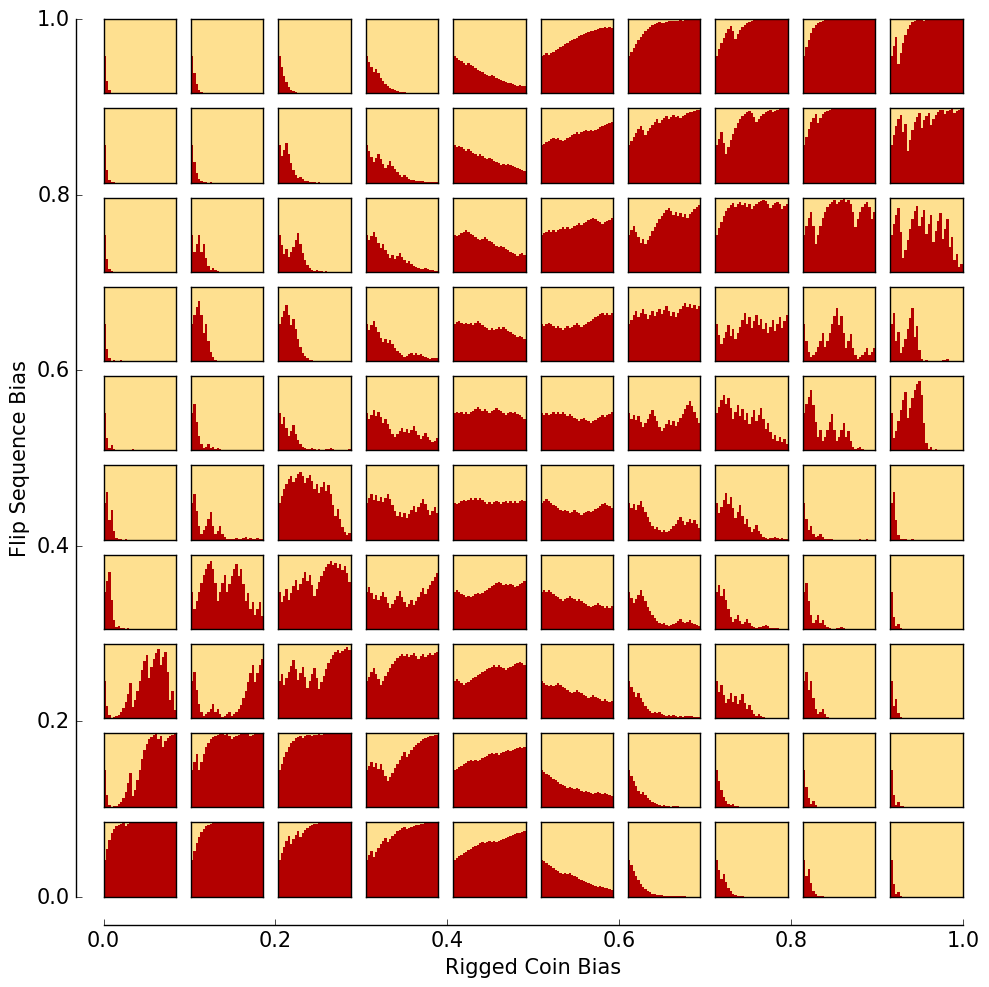

In [17]:
CFG_make_grid(number_of_flips = 30)

In [18]:
# SLOW! This one takes a long time to run
# CFG_make_grid(number_of_flips = 1000)

In [19]:
##### SECTION 4: Multiple Hypotheses (MH)

In [20]:
sns.set()    # Turn seaborn back on

In [21]:
MH_prior_color = '#FC4349'   # dark red
MH_numerator_color = '#ff0000'  # bright red - unused
MH_posterior_color = '#5968B2'  # dark blue
Heads_color = '#DA9700'  # ochre
Tails_color = '#04A47A'  # foam green
multi_bar_width = 0.35

In [22]:
def MH_make_legend_figure():
    plt.figure(figsize=(10, 4.5))
    
    plt.subplot(1,2,1)
    xs = [0, .25, .5, .75, 1]
    ys = [0, .25, .5, .75, 1]
    bar_width = 0.8
    plt.bar(range(len(xs)), ys, bar_width, label='Rigged', color=Heads_color, edgecolor = "none")
    plt.xlim(0, len(xs))
    plt.ylim(0, 1)
    tick_pos = [i+(bar_width/2) for i in range(len(xs))] 
    tick_labels = ['Hyp '+str(i) for i in range(5)]
    plt.xticks(tick_pos, tick_labels, rotation=-90, fontsize=12)
    plt.title('Heads likelihood')
    
    
    plt.subplot(1,2,2)
    xs = [0, .25, .5, .75, 1]
    ys = [1, .75, .5, .25, 0]
    plt.bar(range(len(xs)), ys, bar_width, label='Rigged', color=Tails_color, edgecolor = "none")
    plt.xlim(0, len(xs))
    plt.ylim(0, 1)
    tick_pos = [i+(bar_width/2) for i in range(len(xs))] 
    tick_labels = ['Hyp '+str(i) for i in range(5)]
    plt.xticks(tick_pos, tick_labels, rotation=-90, fontsize=12)
    plt.title('Tails likelihood')


    file_helper.save_figure('legend-figure')
    plt.show()

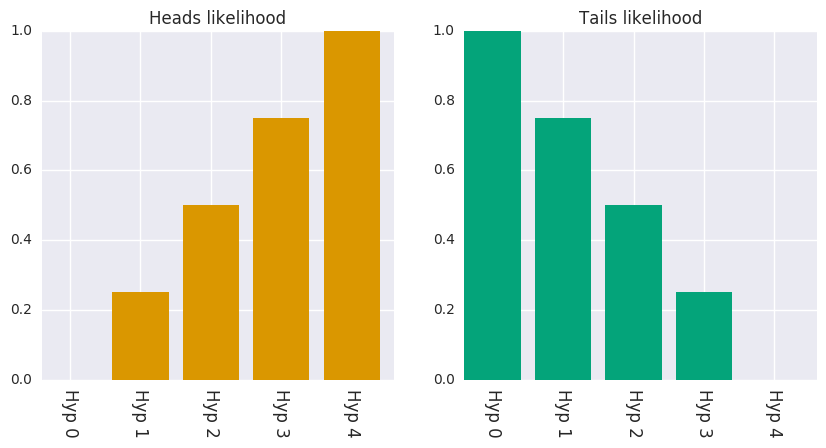

In [23]:
MH_make_legend_figure()

In [24]:
# return the numerator, and posterior, of Bayes rule with our likelihoods
def MH_process_prior(prior, heads):
    numerator = []
    for i in range(len(prior)):
        x = i/(len(prior)-1)
        if heads:
            numerator.append(prior[i]*x)
        else:
            numerator.append(prior[i]*(1-x))
    denominator = np.sum(numerator)
    posterior = [n/denominator for n in numerator]
    return (numerator, posterior)

In [25]:
def MH_draw_trio_bars(prior, numerator, posterior, showTicks):
    # I was going to plot the numerator too (hence "trio") but it's not needed
    range_prior = [r for r in range(len(posterior))]
    range_posterior = [multi_bar_width+r for r in range(len(posterior))]
    plt.bar(range_prior, prior, multi_bar_width, color=MH_prior_color, edgecolor="none")
    plt.bar(range_posterior, posterior, multi_bar_width, color=MH_posterior_color, edgecolor="none")
    if not showTicks:
        plt.xticks([],[])
        plt.yticks([],[])

In [26]:
def MH_draw_trio_curves(prior, numerator, posterior, showTicks):
    # I was going to plot the numerator too (hence "trio") but it's not needed
    plt.plot(prior, lw=2, color=MH_prior_color)
    plt.plot(posterior, lw=2, color=MH_posterior_color)
    if not showTicks:
        plt.xticks([],[])
        plt.yticks([],[])

In [27]:
def MH_draw_set(rows, columns, prior, 
                              report_after_flip, heads_tails_list, scale_y=False, showTicks=True, use_bars=True):
    num_flips = max(report_after_flip)
    plot_number = 1
    for flip_number in range(1+num_flips):
        heads = heads_tails_list[flip_number]
        (numerator, posterior) = MH_process_prior(prior, heads)

        if flip_number in report_after_flip:
            plt.subplot(rows, columns, plot_number)
            if use_bars:
                MH_draw_trio_bars(prior, numerator, posterior, showTicks)
            else:
                MH_draw_trio_curves(prior, numerator, posterior, showTicks)
            title = 'Flip '+str(flip_number)
            if flip_number < 10:
                if heads:
                    title += ' (Heads)'
                else:
                    title += ' (Tails)'
            plt.title(title, fontsize=15)
            if scale_y:
                y_max = max(max(prior), max(numerator), max(posterior))
                y_max *= 1.1
                plt.ylim(0, y_max)
            plot_number += 1
        
        prior = posterior

In [28]:
def MH_make_single_set():
    plt.figure(figsize=(3,3))
    heads_tails_list = [True]
    report_after_flip = [0]
    prior = [.2, .2, .2, .2, .2]
    MH_draw_set(1, 1, prior, report_after_flip, heads_tails_list, showTicks=True, use_bars=True) 
    x_pos = [multi_bar_width+x for x in range(len(prior))]
    plt.xticks(x_pos,['Hyp 0','Hyp 1','Hyp 2', 'Hyp 3', 'Hyp 4'], rotation=-90, fontsize=12)
    plt.yticks([0, .2, .4, .6, .8, 1],[0, .2, .4, .6, .8, 1], fontsize=12)
    file_helper.save_figure('MH-set-1')
    plt.show()

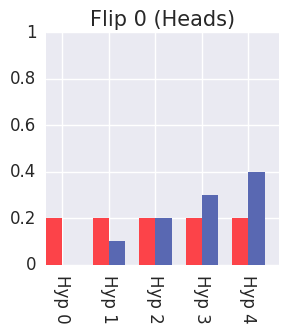

In [29]:
MH_make_single_set()

In [30]:
def MH_make_multi_set():
    bias = 0.3;
    plt.figure(figsize=(10,6))
    np.random.seed(43)
    flip_results = np.random.uniform(size=5003)
    heads_tails_list = [f < bias for f in flip_results]
    report_after_flip = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 50, 100]
    prior = [.2, .2, .2, .2, .2]
    MH_draw_set(3, 5, prior, report_after_flip, heads_tails_list, showTicks=False, use_bars=True)            
    file_helper.save_figure('MH-set-2')
    plt.tight_layout()
    plt.show()

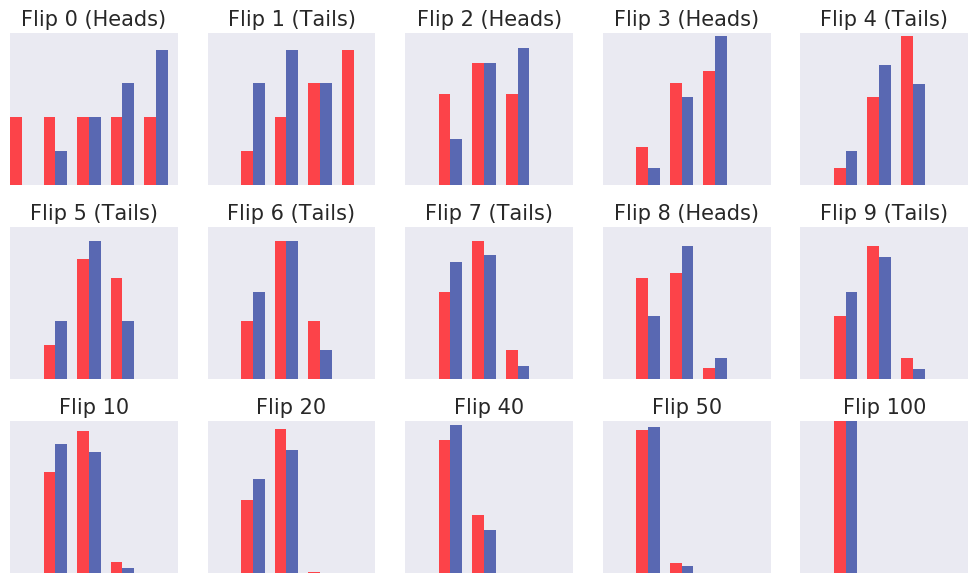

In [31]:
MH_make_multi_set()

In [32]:
def MH_make_multi_highres_set():
    bias = 0.3;
    plt.figure(figsize=(10,8))
    np.random.seed(43)
    flip_results = np.random.uniform(size=5003)
    heads_tails_list = [f < bias for f in flip_results]
    report_after_flip = [0, 1, 2, 3, 4, 
                         5, 6, 7, 8, 9, 
                         10, 20, 40, 50, 100,
                         150, 200, 300, 1000, 5000]
    prior = 500*[.2]
    MH_draw_set(4, 5, prior, report_after_flip, heads_tails_list, scale_y=True, showTicks=False, use_bars=False)            
    file_helper.save_figure('MH-set-3')
    plt.tight_layout()
    plt.show()

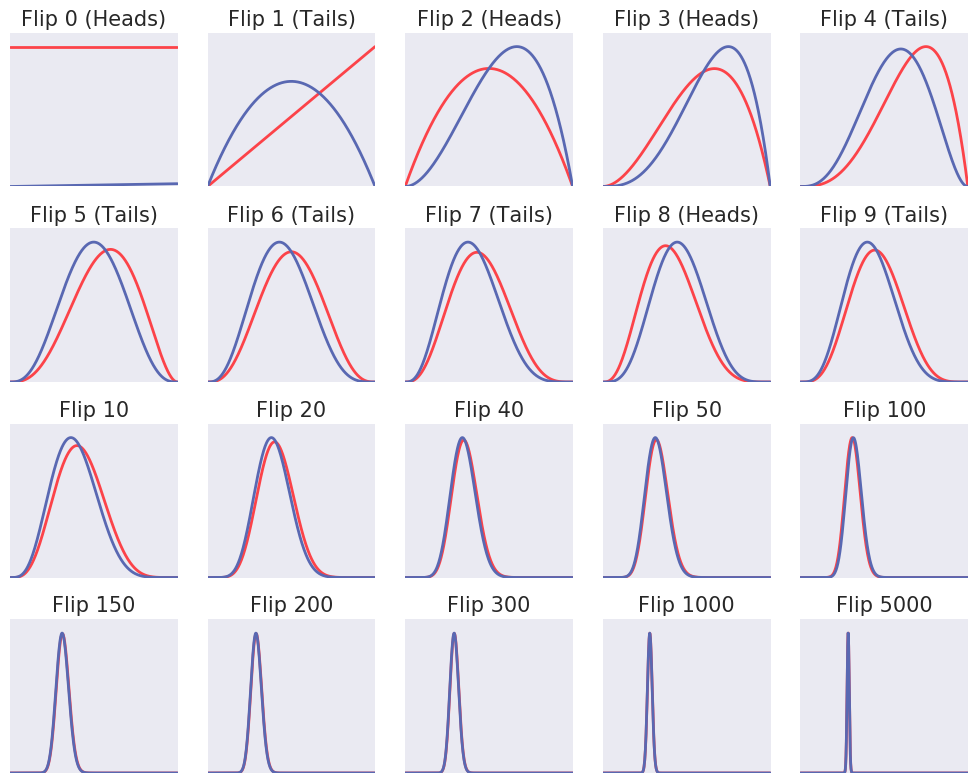

In [33]:
MH_make_multi_highres_set()

In [34]:
def MH_make_multi_highres_set_starting_gaussian():
    bias = 0.3;
    plt.figure(figsize=(10,8))
    np.random.seed(43)
    flip_results = np.random.uniform(size=5003)
    heads_tails_list = [f < bias for f in flip_results]
    report_after_flip = [0, 1, 2, 3, 4, 
                         5, 6, 7, 8, 9, 
                         10, 20, 40, 50, 100,
                         1000, 2000, 3000, 4000, 5000]
    prior = []
    for x in range(-250, 250):
        f = (x-150)/100
        prior.append(math.exp(-f*f))
    MH_draw_set(4, 5, prior, report_after_flip, heads_tails_list, scale_y=True, showTicks=False, use_bars=False)            
    file_helper.save_figure('MH-set-4')
    plt.tight_layout()
    plt.show()

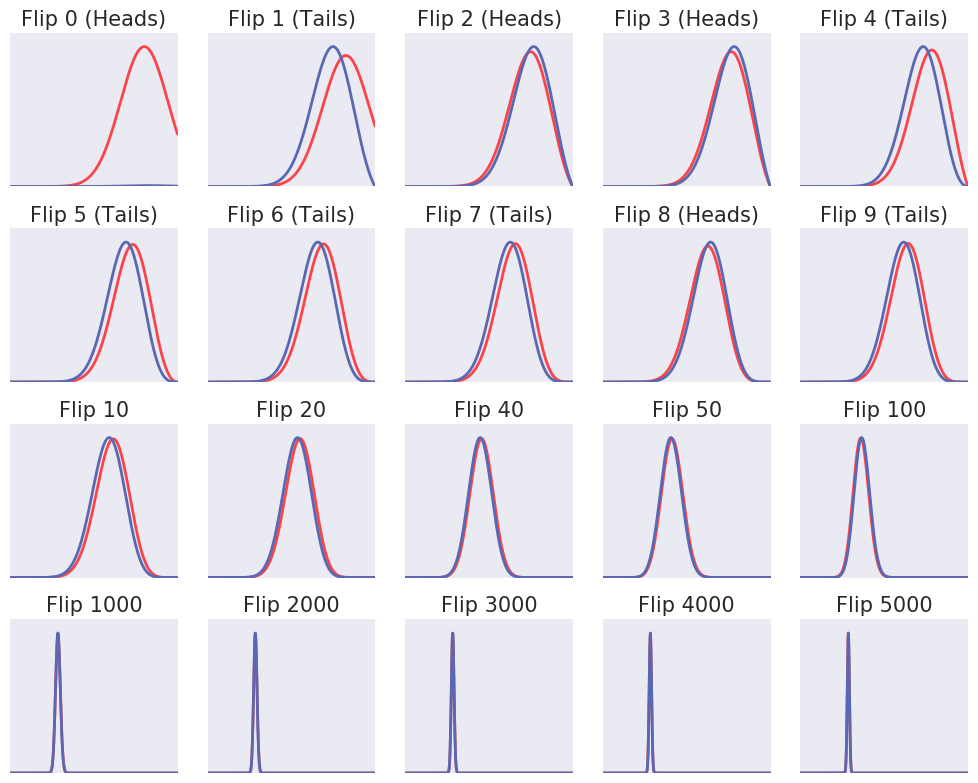

In [35]:
MH_make_multi_highres_set_starting_gaussian()

In [36]:
def MH_make_time_lapse():
    number_of_flips = 5001
    plot_schedule = [0, 20, 40, 60, 200, 400, 600, 900, 1500, 3000]
    plt.figure(figsize=(10,7))
    bias = 0.3;
    np.random.seed(43)
    flip_results = np.random.uniform(size=5003)
    heads_tails_list = [f < bias for f in flip_results]
    prior = []
    for x in range(-250, 250):
        f = (x-150)/100
        prior.append(math.exp(-f*f))
    for i in range(1+max(plot_schedule)):
        heads = heads_tails_list[i]
        (numerator, posterior) = MH_process_prior(prior, heads)
        if i in plot_schedule:
            plt.plot(range(len(posterior)), posterior, label=i, lw=2)
        prior = posterior
    plt.xticks([0, 100, 200, 300, 400, 500],[0, .2, .4, .6, .8, 1])
    plt.legend(loc='upper right')
    file_helper.save_figure('time-lapse')
    plt.show()

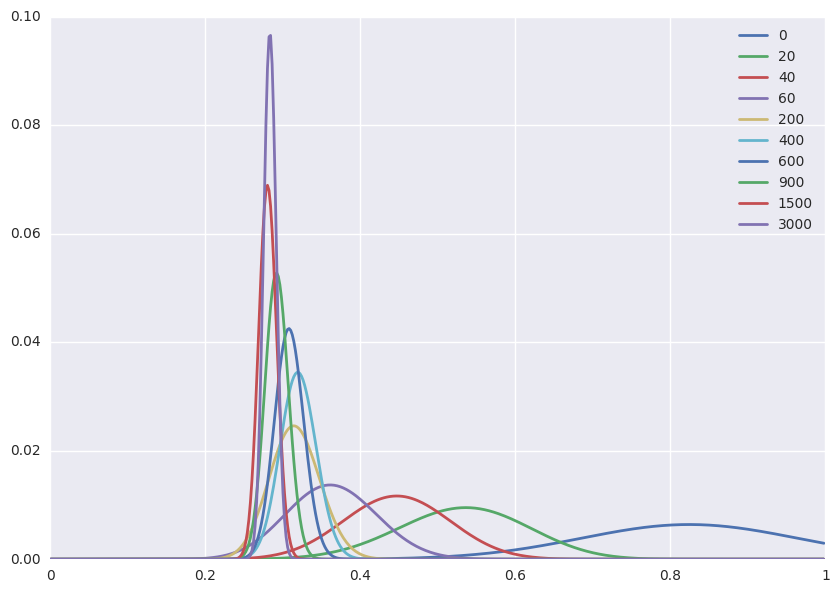

In [37]:
MH_make_time_lapse()